<a href="https://colab.research.google.com/github/ParitoshP702/Time_Series_Analysis/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import yfinance as yf
#get data on this ticker
tickerData = yf.Ticker("AAPL")
tickerDf = tickerData.history(period = "1mo", start = "2010-10-13", end = "2022-10-13")
tickerDf = tickerDf[['Close']]
start = "2020-10-13"
end = "2022-10-13"


In [3]:
tickerDf = tickerDf.dropna()
tickerDf

,Close
Date,
2010-10-13 00:00:00-04:00,9.152471
2010-10-14 00:00:00-04:00,9.218638
2010-10-15 00:00:00-04:00,9.597681
2010-10-18 00:00:00-04:00,9.697095
2010-10-19 00:00:00-04:00,9.437590
...,...
2022-10-06 00:00:00-04:00,145.429993
2022-10-07 00:00:00-04:00,140.089996
2022-10-10 00:00:00-04:00,140.419998


In [4]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

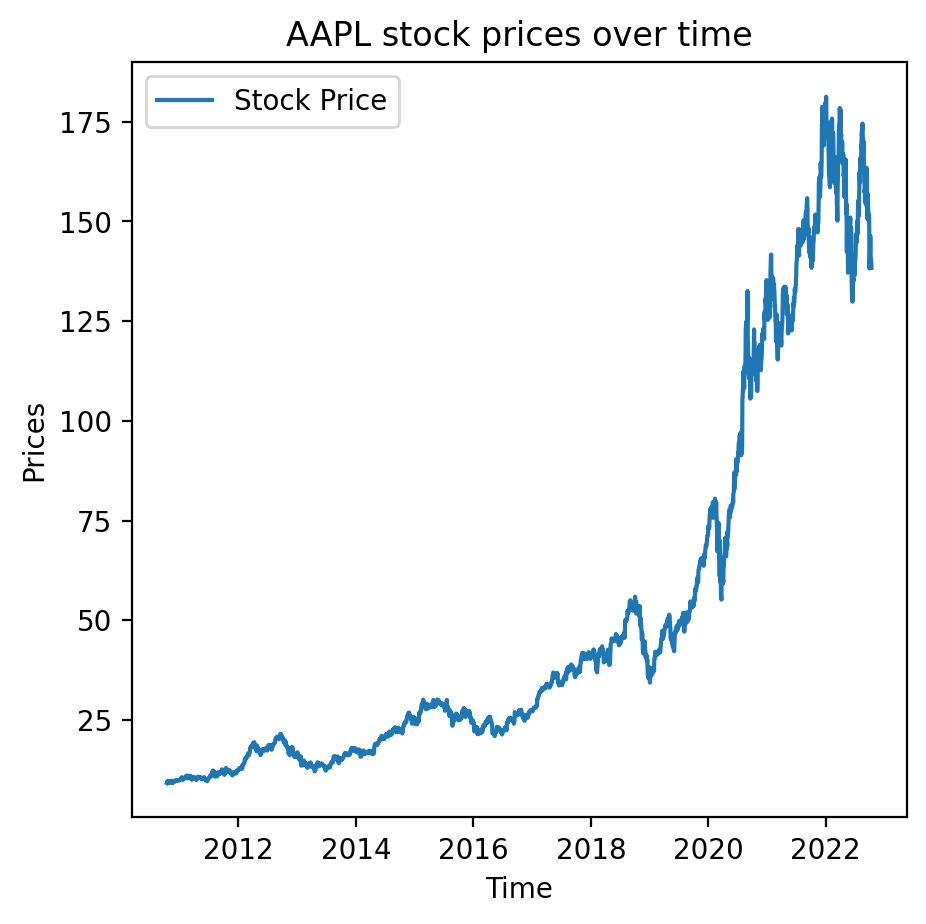

In [6]:
#Plotting our stock data
plt.figure(figsize = (5,5), dpi = 200)
plt.plot(tickerDf.index, tickerDf, label = "Stock Price")
plt.xlabel("Time")
plt.ylabel("Prices")
plt.title("AAPL stock prices over time")
#for year in range(2010,2022):
  #plt.axvline(pd.to_datetime(str(year)+"01-01"), linestyle = "--",color = "k")
plt.legend();

<Figure size 1000x1000 with 0 Axes>

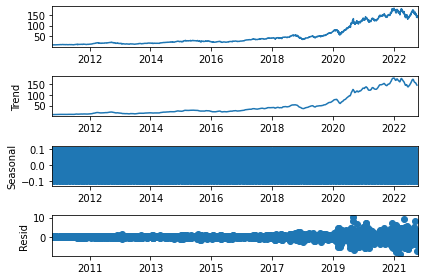

In [7]:
plt.figure(figsize = (5,5), dpi = 200)
seasonal_decompose(tickerDf, period= 12).plot()
plt.show()

Clearly our data is not stationary , we can check this formally using the augmented dickey fuller test

In [8]:
stat_test = adfuller(tickerDf)[0:2]
print(f"The ADF test statistics  and p-value are:{(stat_test)}")


The ADF test statistics  and p-value are:(0.07429790964603074, 0.9642618446771515)


# Moving Average(MA) model:

Since the p-value is greater than 0.05, we can clearly state that the time series data is non stationary. However, we can make it stationary by taking the first difference of our time series data

In [9]:
first_diff_aapl = tickerDf.diff().dropna()
first_diff_aapl


,Close
Date,
2010-10-14 00:00:00-04:00,0.066168
2010-10-15 00:00:00-04:00,0.379043
2010-10-18 00:00:00-04:00,0.099414
2010-10-19 00:00:00-04:00,-0.259505
2010-10-20 00:00:00-04:00,0.031712
...,...
2022-10-06 00:00:00-04:00,-0.970001
2022-10-07 00:00:00-04:00,-5.339996
2022-10-10 00:00:00-04:00,0.330002


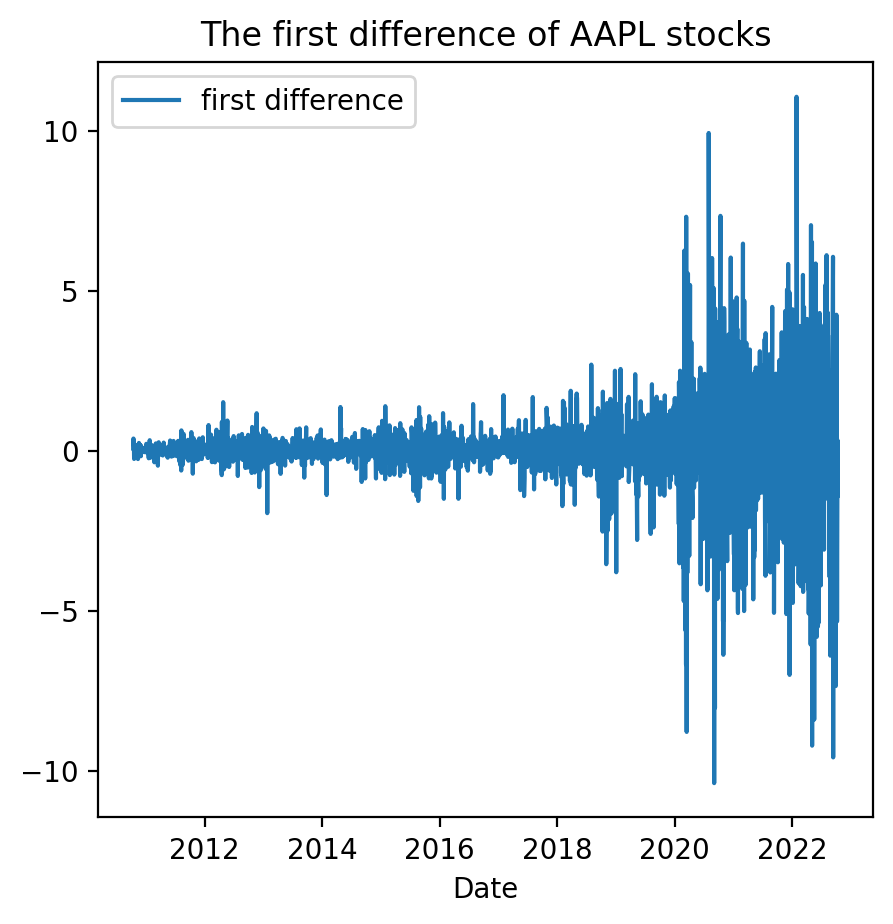

In [10]:
#Plotting the first difference
plt.figure(figsize = (5,5), dpi = 200)
plt.plot(first_diff_aapl.index, first_diff_aapl, label = "first difference")
plt.xlabel("Date")
plt.title("The first difference of AAPL stocks")
plt.legend(loc = "best")

In [11]:
#Creating training and test splits
split = int(len(first_diff_aapl)*0.95)
train_first_diff_aapl = first_diff_aapl.iloc[:split]
test_first_diff_aapl = first_diff_aapl.iloc[split:]

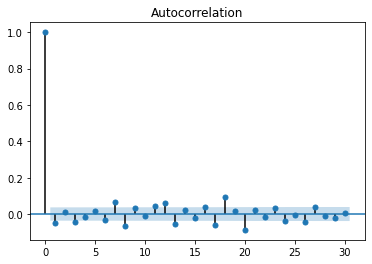

In [12]:
#Plotting the autocorrelation function of our training dataset to check for seasonality
acf_plot = plot_acf(train_first_diff_aapl, lags = 30)

Clearly by seeing the ACF graphs of our dataset we can say that we can choose an order of 8 to be our short term order and an order of 20 to be our long term order

In [13]:
train_aapl_short_term = train_first_diff_aapl.rolling(window = 8).mean()
train_aapl_long_term = train_first_diff_aapl.rolling(window = 20).mean()

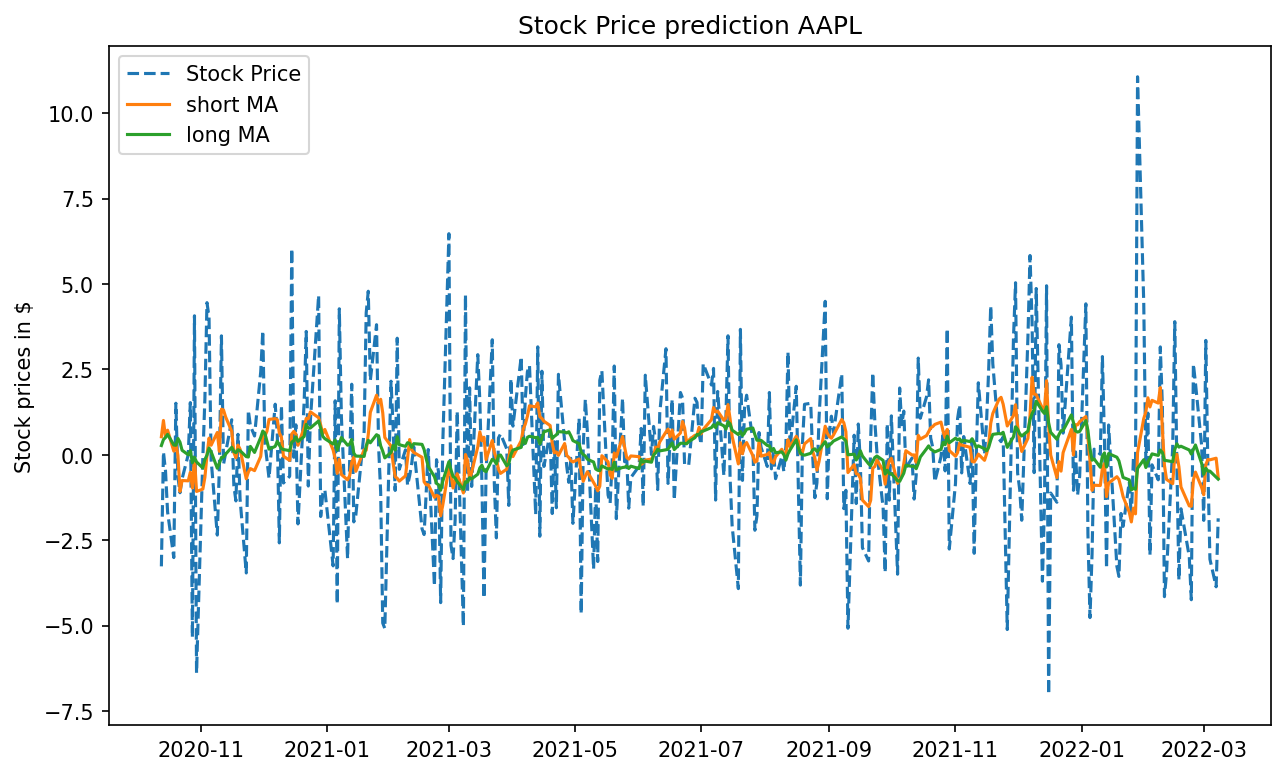

In [14]:
fig, ax = plt.subplots(figsize = (10,6), dpi = 150)
ax.plot(train_first_diff_aapl.loc[start:end].index, train_first_diff_aapl.loc[start:end],label = "Stock Price", linestyle = "--")
ax.plot(train_aapl_short_term.loc[start:end].index,train_aapl_short_term.loc[start:end],label = "short MA",linestyle = "solid")
ax.plot(train_aapl_long_term.loc[start:end].index,train_aapl_long_term.loc[start:end],label = "long MA", linestyle = "solid")
ax.legend(loc= "best")
ax.set_ylabel("Stock prices in $")
ax.set_title("Stock Price prediction AAPL");

# Autoregressive Model

In order to find out the true order for our AR model prediction , we will need the Partial Autocorrelation function (PACF)

<Figure size 1200x1200 with 0 Axes>

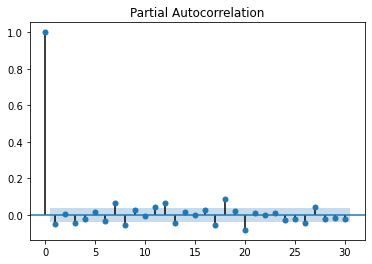

In [15]:
plt.figure(figsize = (6,6),dpi = 200)
pacf_plot = plot_pacf(train_first_diff_aapl,lags = 30)


In [16]:
#Hence we can take an order of 27 lags for our AutoRegressive model
import warnings
warnings.filterwarnings("ignore")

In [17]:
from statsmodels.tsa.ar_model import AutoReg
ar_aapl = AutoReg(train_first_diff_aapl.values, lags = 27)
ar_fit_aapl = ar_aapl.fit()

In [18]:
predicted_ar_aapl = ar_fit_aapl.predict(start = len(train_first_diff_aapl),end = len(train_first_diff_aapl)+len(test_first_diff_aapl)-1,dynamic = False)


In [19]:
ar_predictions_aapl = pd.DataFrame(predicted_ar_aapl)

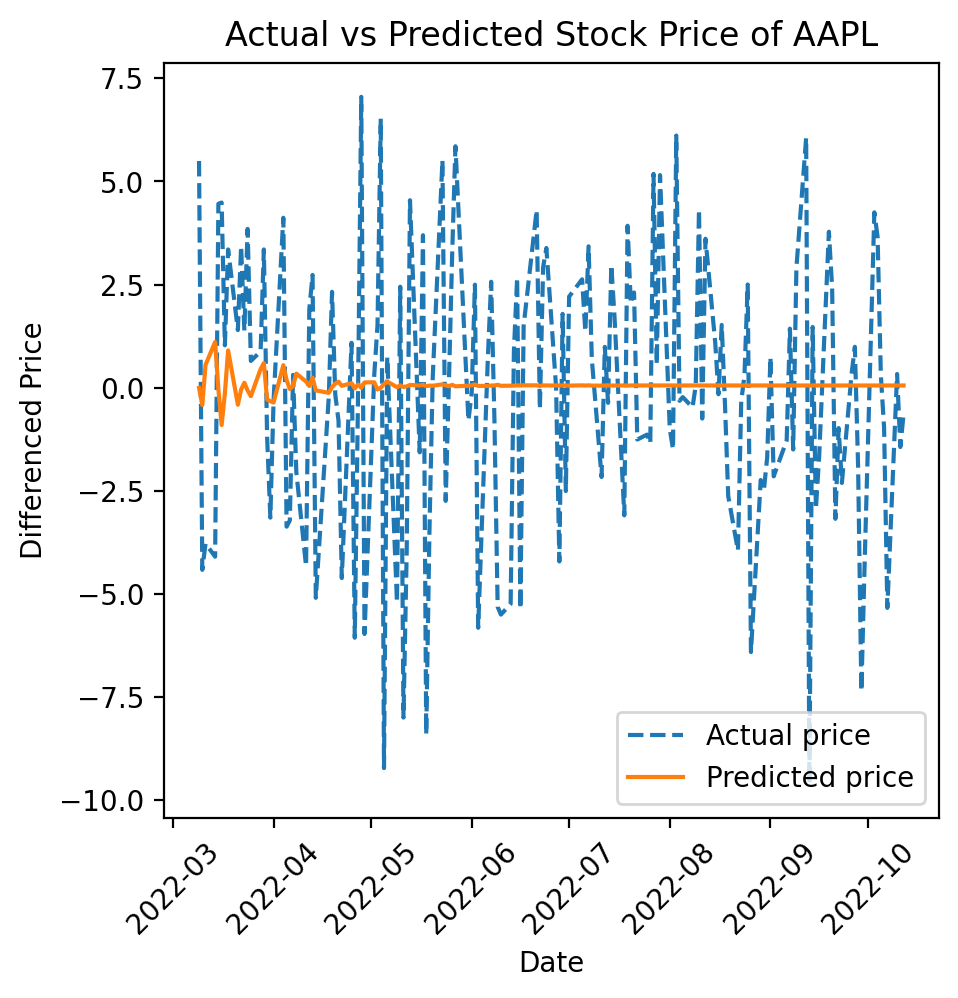

In [20]:
#plotting our orignal and predicted values in the training period
plt.figure(figsize = (5,5), dpi = 200)
plt.plot(test_first_diff_aapl.index,test_first_diff_aapl, label = "Actual price", linestyle = "--")
plt.plot(test_first_diff_aapl.index,ar_predictions_aapl.values, label = "Predicted price",linestyle = "solid")
plt.legend(loc = "best")
plt.ylabel("Differenced Price")
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.title("Actual vs Predicted Stock Price of AAPL");

# ARIMA(Autoregressive Integrated Moving Average)Model:
The benefit of this model is that even if we provide non stationary raw data , the model makes it stationary by defining a suitable integration parameter.

In [21]:
from statsmodels.tsa.arima_model import ARIMA

In [22]:
split = int(len(tickerDf)*0.95)
train_aapl = tickerDf[:split]
test_aapl = tickerDf[split:]

In [23]:
len(train_aapl),len(test_aapl)

(2869, 152)

We will first fit the model by using an arbitrary order of (8,1,8)

In [24]:
arima_aapl = ARIMA(train_aapl, order = (8,1,8))
arima_fit_aapl = arima_aapl.fit()

In [25]:
arima_predict_aapl = arima_fit_aapl.predict(start = len(train_aapl),end = len(train_aapl)+len(test_aapl)-1, dynamic = False)

In [26]:
arima_prediction_aapl = pd.DataFrame(arima_predict_aapl)
arima_prediction_aapl.index = test_aapl.index

In [27]:
arima_prediction_aapl

,0
Date,
2022-03-08 00:00:00-05:00,-0.736501
2022-03-09 00:00:00-05:00,-0.908282
2022-03-10 00:00:00-05:00,-0.229844
2022-03-11 00:00:00-05:00,0.034281
2022-03-14 00:00:00-04:00,0.456221
...,...
2022-10-06 00:00:00-04:00,0.007601
2022-10-07 00:00:00-04:00,0.218581
2022-10-10 00:00:00-04:00,0.051830


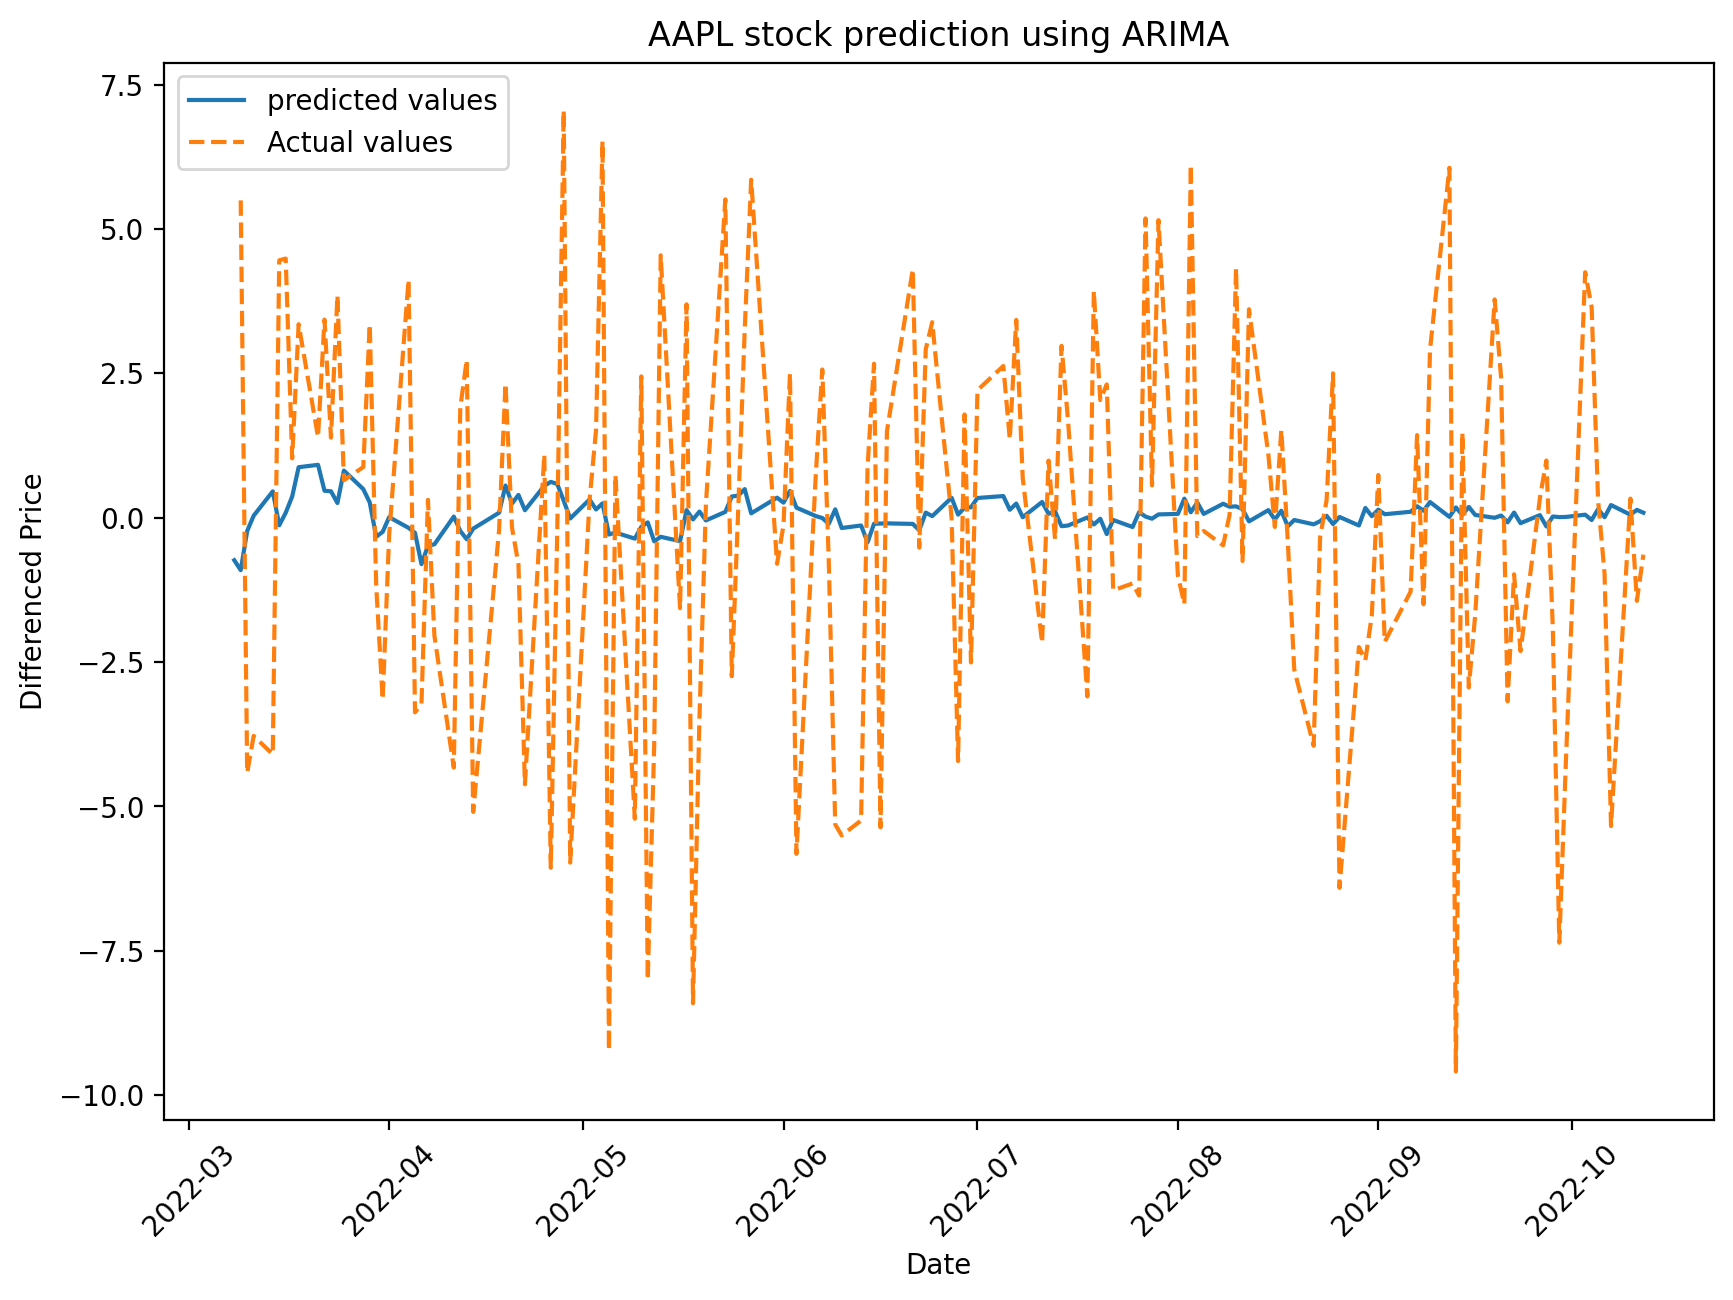

In [28]:
#Plotting our results
plt.figure(figsize = (10,7),dpi = 200)
plt.plot(arima_prediction_aapl.index,arima_prediction_aapl.values,label = "predicted values",linestyle = "solid")
plt.plot(test_first_diff_aapl.index,test_first_diff_aapl.values,label = "Actual values",linestyle = "--")
plt.xlabel("Date")
plt.ylabel("Differenced Price")
plt.xticks(rotation = 45)
plt.title("AAPL stock prediction using ARIMA")
plt.legend(loc = "best");

# Now we are going to predict the most adequate order for our ARIMA model using AIC(Aikake Information Criteria)

In [29]:
import itertools
p = q= range(0,8)
d = range(0,3)
pdq = list(itertools.product(p,d,q))
arima_results_aapl = []
for param_set in pdq:
  try:
    arima_train_aapl = ARIMA(train_aapl, order = param_set)
    arima_fitted_aapl = arima_train_aapl.fit()
    arima_results_aapl.append(arima_fitted_aapl.aic)
  except:
    continue
print("**"*25)
print("The lowest aic score is {:.4f} and the most adequate order for ARIMA model is{}".format(pd.DataFrame(arima_results_aapl).where(pd.DataFrame(arima_results_aapl).T.notnull().all()).min()[0],
                                                                                              pdq[arima_results_aapl.index(min(arima_results_aapl))]))  

**************************************************
The lowest aic score is 8868.4381 and the most adequate order for ARIMA model is(3, 0, 5)


In [31]:
arima_aapl = ARIMA(train_aapl, order =(3,1,5) )
arima_fit_aapl = arima_aapl.fit()
arima_predict_aapl = arima_fit_aapl.predict(start = len(train_aapl), end = len(train_aapl)+len(test_aapl)-1, dynamic = False)
arima_prediction_aapl = pd.DataFrame(arima_predict_aapl)
arima_prediction_aapl.index = test_aapl.index

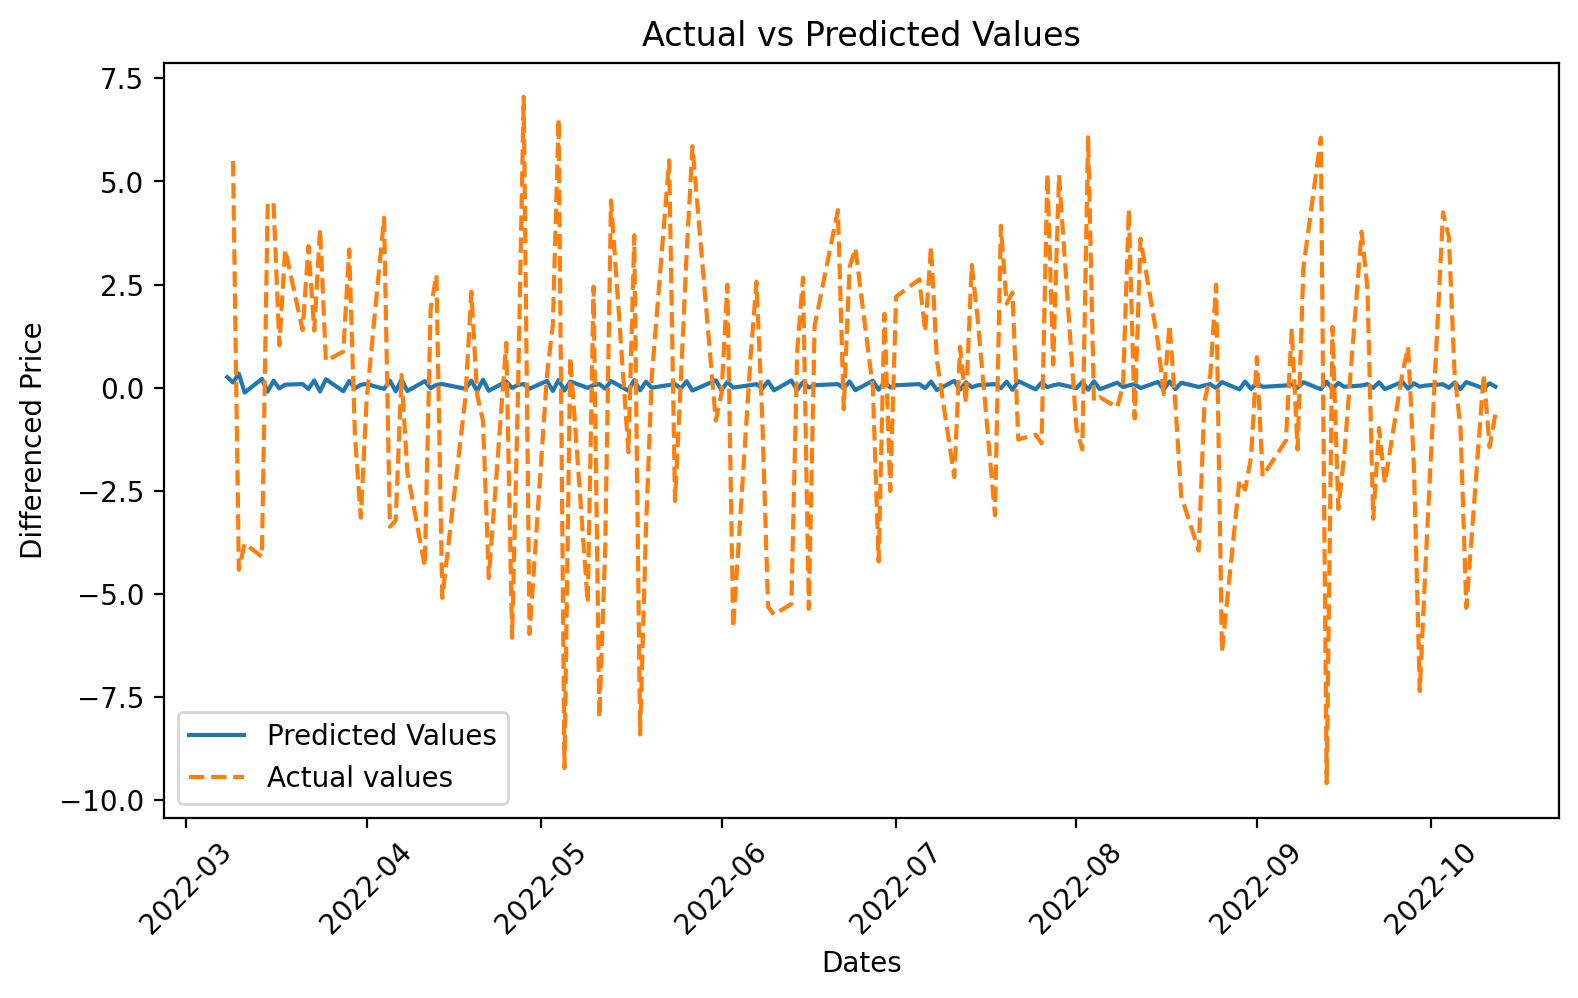

In [36]:
plt.figure(figsize = (9,5), dpi = 200)
plt.plot(arima_prediction_aapl.index,arima_prediction_aapl.values, label = "Predicted Values", linestyle = "solid")
plt.plot(test_first_diff_aapl.index, test_first_diff_aapl.values, label = "Actual values", linestyle = "--")
plt.xlabel("Dates")
plt.ylabel("Differenced Price")
plt.xticks(rotation = 45)
plt.title("Actual vs Predicted Values")
plt.legend(loc = "best");